# Parameter recovery of the DDM with starting point bias

In [1]:
import rlssm
import pandas as pd

## Simulate individual data

In [3]:
from rlssm.random import simulate_ddm

In [4]:
data = simulate_ddm(
    n_trials=400, 
    gen_drift=.8, 
    gen_threshold=1.3, 
    gen_ndt=.23, 
    gen_rel_sp=.6)

In [5]:
data.describe()[['rt', 'accuracy']]

,rt,accuracy
count,400.000000,400.000000
mean,0.564827,0.840000
std,0.285185,0.367065
min,0.261000,0.000000
25%,0.361750,1.000000
50%,0.476000,1.000000
75%,0.667000,1.000000
max,1.741000,1.000000


## Initialize the model

In [6]:
model = rlssm.DDModel(hierarchical_levels = 1, starting_point_bias=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ba90c9ff5918c4555b6b624f8591f02b NOW.


## Fit

In [7]:
# sampling parameters
n_iter = 3000
n_chains = 2
n_thin = 1

# bayesian model, change default priors:
drift_priors = {'mu':1, 'sd':3}
threshold_priors = {'mu':-1, 'sd':3}
ndt_priors = {'mu':-1, 'sd':1}

In [8]:
model_fit = model.fit(
    data,
    drift_priors=drift_priors,
    threshold_priors=threshold_priors,
    ndt_priors=ndt_priors,
    thin = n_thin,
    iter = n_iter,
    chains = n_chains,
    verbose = False)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Checks MCMC diagnostics:
n_eff / iter looks reasonable for all parameters
0.0 of 3000 iterations ended with a divergence (0.0%)
0 of 3000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


### get Rhat

In [9]:
model_fit.rhat

,rhat,variable
0,0.999463,drift
1,0.999428,threshold
2,0.999969,ndt
3,0.999633,rel_sp


### calculate wAIC

In [11]:
model_fit.waic

{'lppd': -84.4165465344934,
 'p_waic': 3.631295141216568,
 'waic': 176.09568335141995,
 'waic_se': 48.46685345606353}

## Posteriors

In [12]:
model_fit.samples.describe()

,chain,draw,transf_drift,transf_threshold,transf_ndt,transf_rel_sp
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.500000,749.500000,0.880803,1.301814,0.234382,0.616586
std,0.500083,433.084792,0.112488,0.034720,0.004773,0.019893
min,0.000000,0.000000,0.513606,1.165148,0.215534,0.524463
25%,0.000000,374.750000,0.805302,1.278279,0.231489,0.603545
50%,0.500000,749.500000,0.884396,1.300699,0.234745,0.616995
75%,1.000000,1124.250000,0.957056,1.324780,0.237767,0.629993
max,1.000000,1499.000000,1.270829,1.414547,0.247698,0.687491


In [13]:
import seaborn as sns
sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(15, 8)})

Here we plot the estimated posterior distributions against the generating parameters, to see whether the model parameters are recovering well:

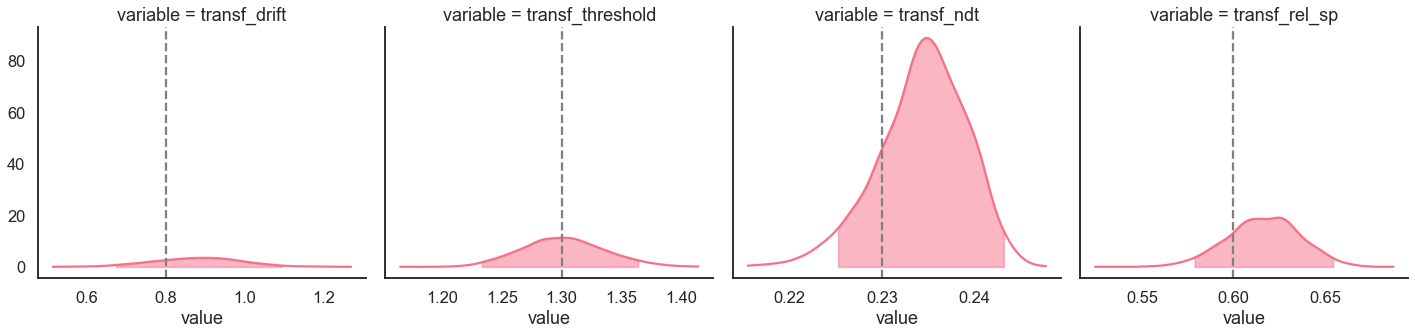

In [14]:
g = model_fit.plot_posteriors(height=5, show_intervals='HDI')

for i, ax in enumerate(g.axes.flatten()):
    ax.axvline(data[['drift', 'threshold', 'ndt', 'rel_sp']].mean().values[i], color='grey', linestyle='--')

## Posterior predictives

### Ungrouped

In [17]:
pp = model_fit.get_posterior_predictives_df(n_posterior_predictives=100)
pp

variable        rt                                                    \
trial          1         2         3         4         5         6     
sample                                                                 
1         0.821036  0.504036  0.468036  0.465036  0.318036  1.204036   
2         0.501778  0.313778  1.004778  0.392778  0.347778  0.725778   
3         0.854016  0.687016  0.493016  0.516016  0.378016  0.500016   
4         0.293640  0.552640  0.617640  0.379640  0.474640  0.373640   
5         0.500683  0.353683  0.699683  0.619683  0.292683  0.419683   
...            ...       ...       ...       ...       ...       ...   
96        0.476602  0.375602  0.500602  0.676602  0.743602  0.342602   
97        0.634989  0.701989  0.405989  0.735989  0.715989  0.803989   
98        0.379868  0.530868  0.337868  0.423868  0.335868  0.509868   
99        1.319686  0.317686  0.345686  0.571686  0.909686  0.709686   
100       0.299539  0.673539  0.384539  0.741539  0.284539  0.342539   

variable                                          ... accuracy                 \
trial          7         8         9         10   ...      391  392  393  394   
sample                                            ...                           
1         0.352036  0.263036  0.385036  0.908036  ...      1.0  0.0  1.0  0.0   
2         0.298778  0.511778  0.670778  0.354778  ...      1.0  0.0  1.0  1.0   
3         0.838016  0.310016  0.478016  0.566016  ...      1.0  0.0  0.0  1.0   
4         0.339640  0.371640  0.602640  0.446640  ...      0.0  1.0  1.0  1.0   
5         0.576683  0.752683  2.052683  0.278683  ...      1.0  0.0  1.0  1.0   
...            ...       ...       ...       ...  ...      ...  ...  ...  ...   
96        0.265602  0.448602  0.544602  0.563602  ...      0.0  0.0  1.0  1.0   
97        1.499989  0.337989  0.928989  0.385989  ...      1.0  1.0  0.0  1.0   
98        0.294868  0.291868  0.445868  0.458868  ...      1.0  1.0  1.0  1.0   
99        0.314686  0.835686  0.308686  0.307686  ...      1.0  1.0  1.0  1.0   
100       0.307539  1.145539  0.772539  1.128539  ...      1.0  0.0  0.0  1.0   

variable                                
trial     395  396  397  398  399  400  
sample                                  
1         1.0  1.0  1.0  1.0  1.0  1.0  
2         1.0  0.0  1.0  1.0  1.0  0.0  
3         1.0  1.0  1.0  1.0  1.0  1.0  
4         1.0  1.0  1.0  1.0  1.0  1.0  
5         1.0  1.0  0.0  0.0  1.0  1.0  
...       ...  ...  ...  ...  ...  ...  
96        0.0  1.0  1.0  1.0  0.0  1.0  
97        1.0  1.0  1.0  1.0  1.0  1.0  
98        1.0  1.0  1.0  0.0  1.0  1.0  
99        1.0  1.0  1.0  1.0  1.0  1.0  
100       1.0  1.0  1.0  1.0  1.0  1.0  

[100 rows x 800 columns]

In [18]:
pp_summary = model_fit.get_posterior_predictives_summary(n_posterior_predictives=100)
pp_summary

,mean_accuracy,mean_rt,skewness,quant_10_rt_low,quant_30_rt_low,quant_50_rt_low,quant_70_rt_low,quant_90_rt_low,quant_10_rt_up,quant_30_rt_up,quant_50_rt_up,quant_70_rt_up,quant_90_rt_up
sample,,,,,,,,,,,,,
1,0.8575,0.584194,2.079916,0.418836,0.514236,0.625036,0.787236,1.063636,0.309036,0.380236,0.461036,0.613436,0.924236
2,0.8600,0.580065,1.592960,0.370278,0.461778,0.611278,0.701778,0.956278,0.307778,0.373678,0.472278,0.653278,0.965978
3,0.8725,0.585961,1.502734,0.357016,0.496016,0.619016,0.722016,0.855016,0.314416,0.376816,0.473016,0.673816,0.992216
4,0.8525,0.561518,1.601840,0.356440,0.463640,0.627640,0.791640,1.183440,0.307640,0.364640,0.456640,0.603640,0.863640
5,0.8350,0.624170,1.914866,0.414683,0.530183,0.680183,0.851683,0.998683,0.305683,0.399383,0.504183,0.674883,1.040183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.8875,0.601067,2.436150,0.439402,0.509602,0.620602,0.795002,1.175002,0.318002,0.389802,0.486602,0.638402,0.947802
97,0.8500,0.568909,1.381673,0.398689,0.506589,0.702989,0.859889,1.204089,0.307889,0.374389,0.453489,0.595589,0.909889
98,0.8125,0.580473,1.910961,0.394868,0.503268,0.554868,0.748068,1.244868,0.307868,0.370268,0.461868,0.626068,0.906268


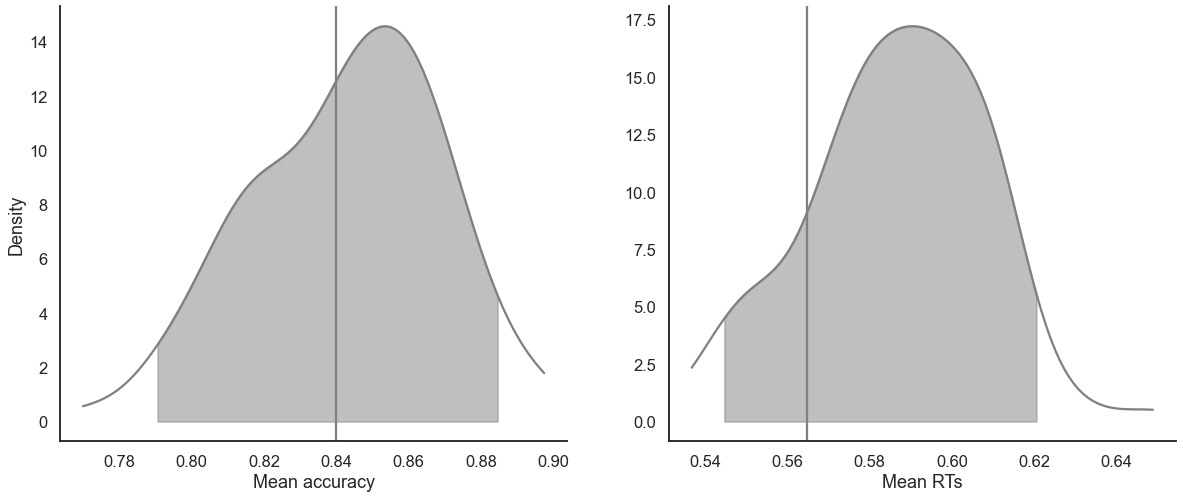

In [19]:
model_fit.plot_mean_posterior_predictives(n_posterior_predictives=100, figsize=(20,8), show_intervals='HDI');

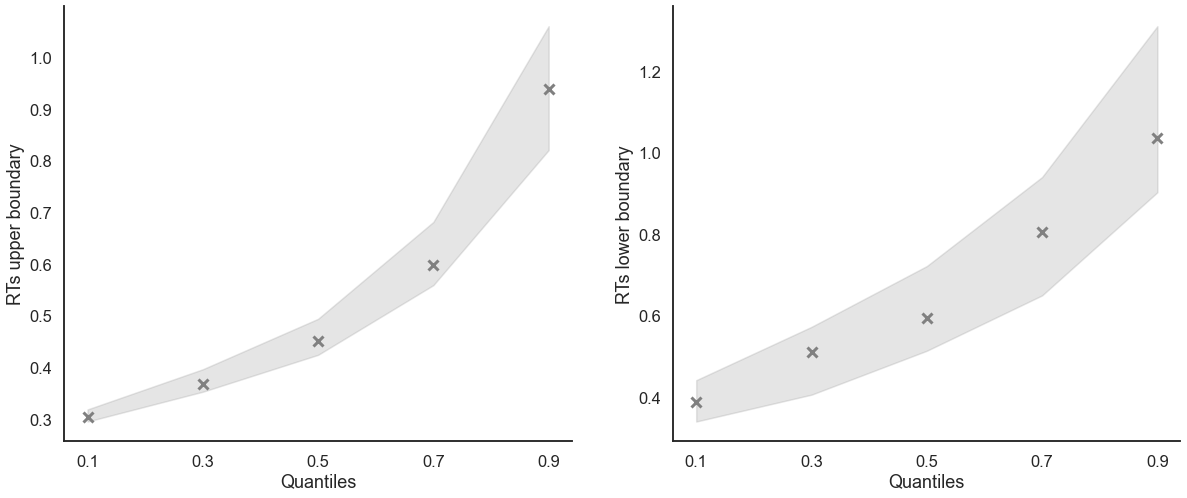

In [20]:
model_fit.plot_quantiles_posterior_predictives(n_posterior_predictives=100, kind='shades');